## LSTM-Driven Battery Health Insights

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
import glob
import time

from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.layers.recurrent import LSTM
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping

from tqdm import tqdm_notebook as tqdm
from ipywidgets import IntProgress

In [2]:
df_35 = pd.read_csv('/CS2_35.csv',index_col=0).dropna()
df_36 = pd.read_csv('/CS2_36.csv',index_col=0).dropna()
df_37 = pd.read_csv('/CS2_37.csv',index_col=0).dropna()
df_38 = pd.read_csv('/CS2_38.csv',index_col=0).dropna()

## Plotting the Parameters
 We will only consider discharge capacity for prediction 

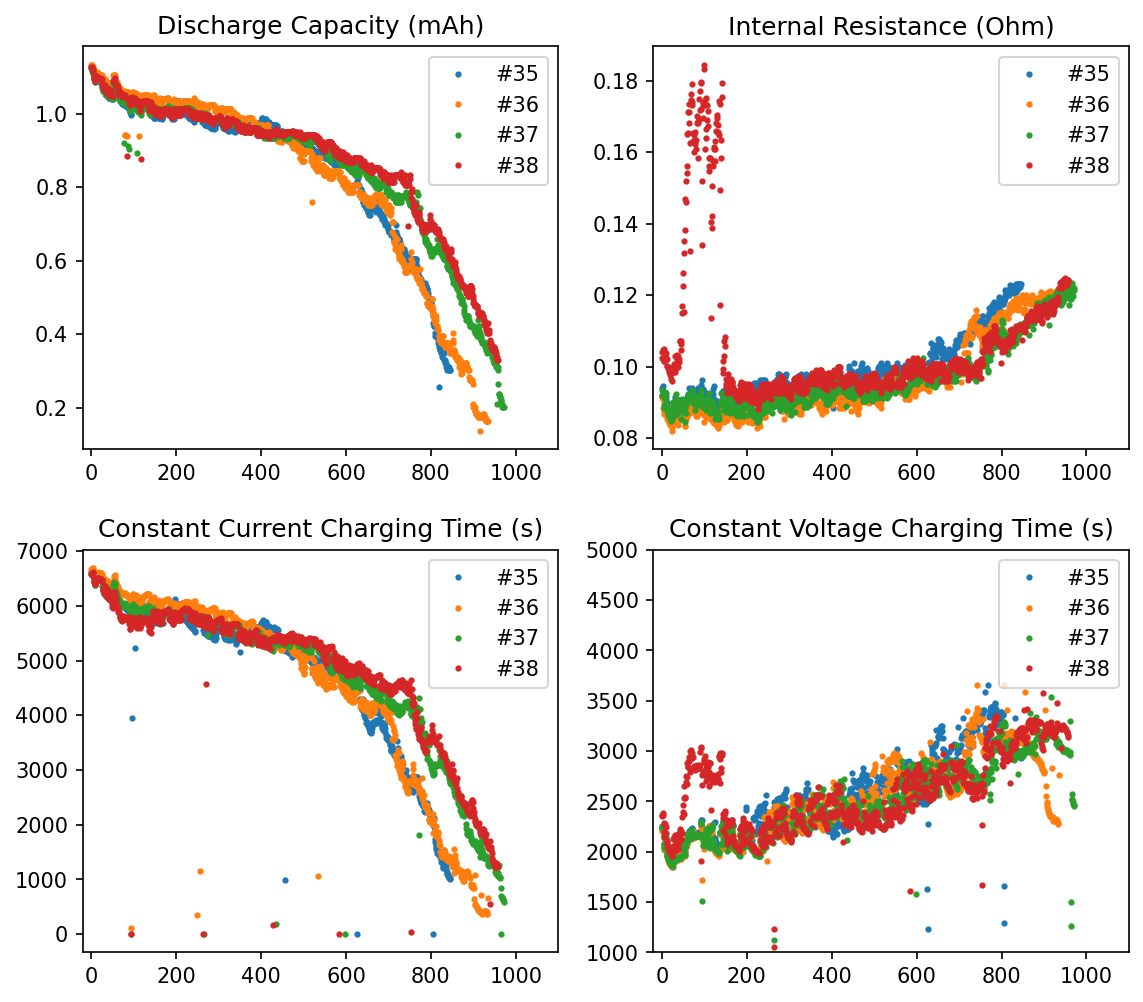

In [3]:
fig = plt.figure(figsize=(9,8),dpi=150)
names = ['capacity','resistance','CCCT','CVCT']
titles = ['Discharge Capacity (mAh)', 'Internal Resistance (Ohm)',
          'Constant Current Charging Time (s)','Constant Voltage Charging Time (s)']
plt.subplots_adjust(hspace=0.25)
for i in range(4):
    plt.subplot(2,2,i+1)
    plt.plot(df_35[names[i]],'o',ms=2,label='#35')
    plt.plot(df_36[names[i]],'o',ms=2,label='#36')
    plt.plot(df_37[names[i]],'o',ms=2,label='#37')
    plt.plot(df_38[names[i]],'o',ms=2,label='#38')
    plt.title(titles[i],fontsize=12)
    plt.legend(loc='upper right')
    if(i == 3):
        plt.ylim(1000,5000)
    plt.xlim(-20,1100)

In [6]:
def Change(data,width):
    
    X_trains = []
    y_trains = []
    
    for df in data:
        length = len(df)

        train_x = np.arange(length)
        capacity = np.array(df['capacity'])
        train_y = capacity
        
        for i in range(length - width):
            X_trains.append(train_y[i:i + width])
            y_trains.append(train_y[i + width])

    X_trains = np.array(X_trains)
    y_trains = np.array(y_trains)
    
    return X_trains,y_trains

In [7]:
X_train,y_train = Change([df_35,df_37,df_38],50)
X_test,y_test = Change([df_36],50)

In [8]:
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(2588, 50) (873, 50) (2588,) (873,)


In [9]:
idx = np.arange(0,X_train.shape[0],1)
idx = np.random.permutation(idx)
idx_lim = idx[:500]

X_train = X_train[idx_lim]
y_train = y_train[idx_lim]

In [10]:
X_train = X_train.reshape([X_train.shape[0], X_train.shape[1], 1])
X_test = X_test.reshape([X_test.shape[0], X_test.shape[1], 1])
y_train = y_train.reshape([y_train.shape[0], 1])
y_test = y_test.reshape([y_test.shape[0], 1])
print(X_train.shape,X_test.shape,y_train.shape,y_test.shape)

(500, 50, 1) (873, 50, 1) (500, 1) (873, 1)


In [11]:
length_of_sequence = X_train.shape[1]
in_out_neurons = 1
n_hidden = 3

model = Sequential()
model.add(LSTM(n_hidden, batch_input_shape=(None, length_of_sequence, in_out_neurons), 
               return_sequences=False,dropout=0))
model.add(Dense(1))
model.add(Activation("linear"))
model.compile(loss="mean_squared_error", optimizer="rmsprop")

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 3)                 60        
                                                                 
 dense (Dense)               (None, 1)                 4         
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________


In [13]:
from livelossplot import PlotLossesKeras

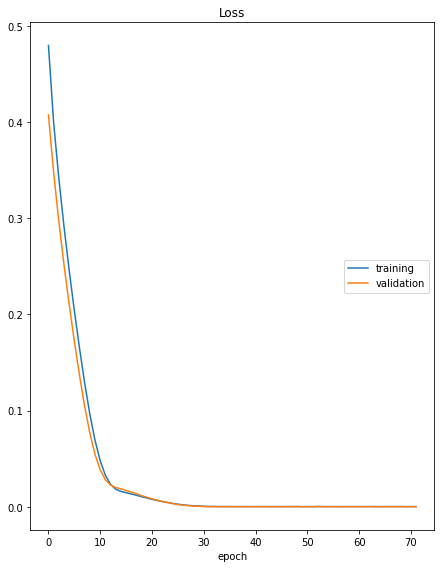

Loss
	training         	 (min:    0.000, max:    0.480, cur:    0.000)
	validation       	 (min:    0.000, max:    0.408, cur:    0.000)
9/9 [==============================] - 1s 71ms/step - loss: 2.1852e-04 - val_loss: 9.7081e-05
CPU times: user 1min 17s, sys: 11.8 s, total: 1min 29s
Wall time: 47.6 s


In [14]:
%%time
early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)
history = model.fit(X_train, y_train,
          batch_size=50,
          epochs=100,
          validation_split=0.1,
          callbacks=[early_stopping,PlotLossesKeras()]
          )

In [15]:
predicted = model.predict(X_train)
predicted = predicted.reshape(predicted.shape[0])

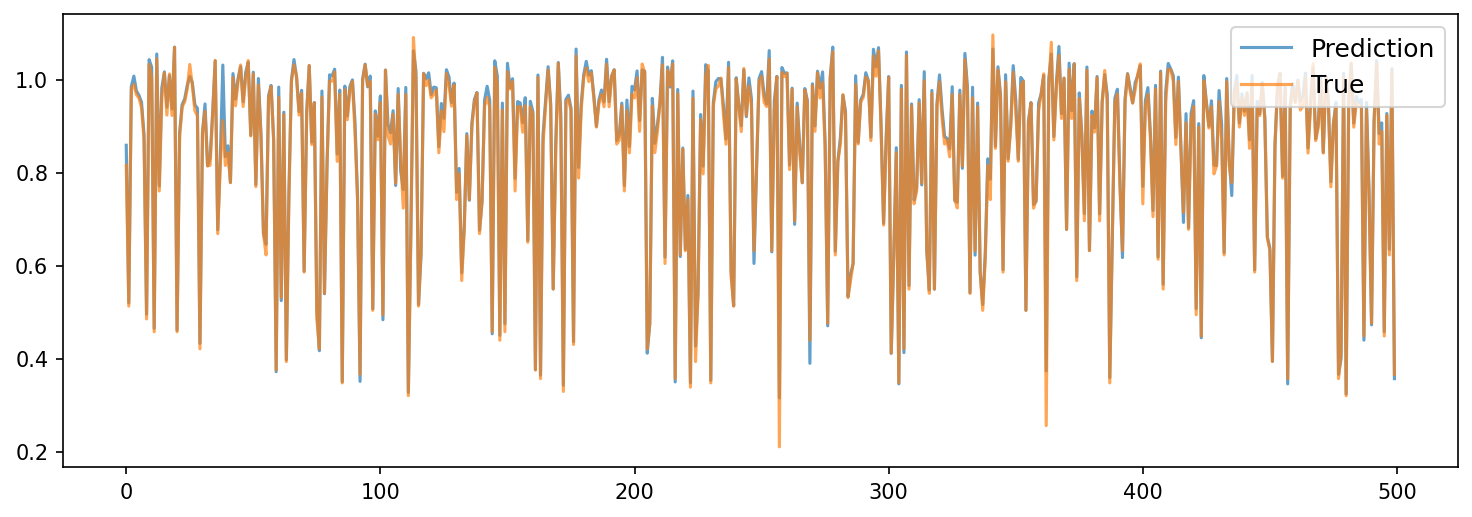

In [16]:
fig=plt.figure(figsize=(12, 4),dpi=150)
plt.plot(predicted,alpha=0.7,label='Prediction')
plt.plot(y_train,alpha=0.7,label='True')
plt.legend(loc='upper right',fontsize=12)

In [17]:
predicted = model.predict(X_test[300:800])
predicted = predicted.reshape(predicted.shape[0])

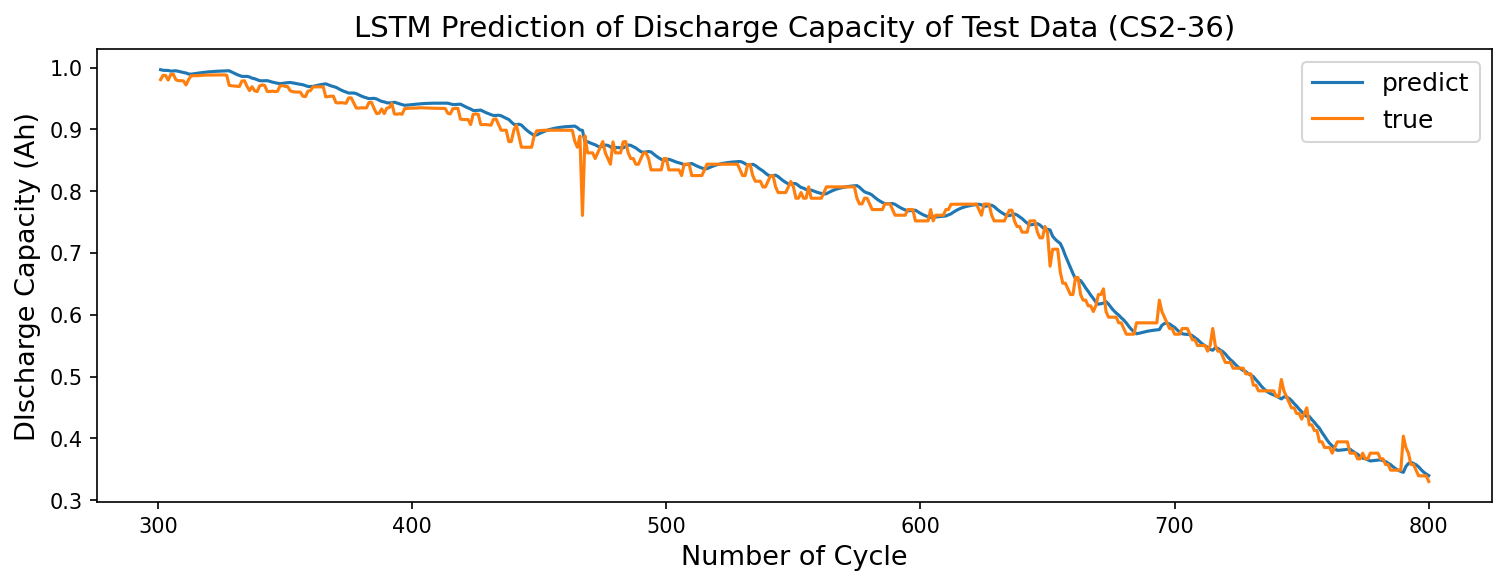

In [18]:
x_range = np.linspace(301,800,500)
fig=plt.figure(figsize=(12, 4),dpi=150)
plt.plot(x_range,predicted,label='predict')
plt.plot(x_range,y_test[300:800],label='true')
plt.xlabel('Number of Cycle',fontsize=13)
plt.ylabel('DIscharge Capacity (Ah)',fontsize=13)
plt.title('LSTM Prediction of Discharge Capacity of Test Data (CS2-36)',fontsize=14)
plt.legend(loc='upper right',fontsize=12)

In [19]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test[300:800], predicted)

0.0002548460125073008